In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#!pip3 install catboost
from catboost import CatBoostClassifier
import catboost

In [11]:
file_path = '/Users/joura/Desktop/Columbia/4525/Project/train.gz'
df = pd.read_csv(file_path, compression='gzip', header='infer')

In [12]:
#unused_cols = ["id", 'site_id', 'app_id']
#df.drop(unused_cols, axis=1, inplace=True)

In [13]:
def get_hour(hour):
    h = str(hour)[4:6]
    return int(h)

df['hour'] = df.hour.apply(get_hour)

In [14]:
C1_values = df.C1.unique()
C1_values.sort()
ctr_avg_list=[]
for i in C1_values:
    ctr_avg=df.loc[np.where(df.C1 == i)].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("C1 value: {},  click through rate: {}".format(i,ctr_avg))

C1 value: 1,  click through rate: 0.06766917293233082
C1 value: 2,  click through rate: 0.23120097197644013
C1 value: 5,  click through rate: 0.20077912965246447
C1 value: 10,  click through rate: 0.2
C1 value: 12,  click through rate: 0.03801555849111992


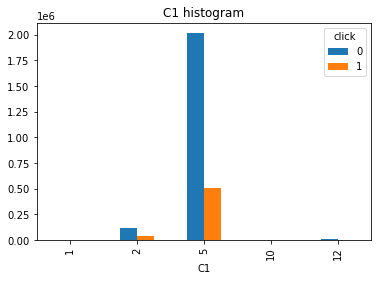

In [15]:
df.groupby(['C1', 'click']).size().unstack().plot(kind='bar', title='C1 histogram')

In [16]:
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(df[['C14','C18','C19','C20','C21']])
df[['C14','C18','C19','C20','C21']] = age_scale_param.transform(df[['C14','C18','C19','C20','C21']])

In [28]:
def convert_obj_to_int(self):
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object or object_list_dtypes[index] == float:
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
df = convert_obj_to_int(df)

In [30]:
#corrmat = df.corr()
#top_corr_features = corrmat.index
#plt.figure(figsize=(20,20))
#g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683787 entries, 0 to 2683786
Data columns (total 24 columns):
 #   Column             Dtype
---  ------             -----
 0   id                 int64
 1   click              int64
 2   hour               int64
 3   C1                 int64
 4   banner_pos         int64
 5   device_type        int64
 6   device_conn_type   int64
 7   C15                int64
 8   C16                int64
 9   C17                int64
 10  site_id_int        int64
 11  site_domain_int    int64
 12  site_category_int  int64
 13  app_id_int         int64
 14  app_domain_int     int64
 15  app_category_int   int64
 16  device_id_int      int64
 17  device_ip_int      int64
 18  device_model_int   int64
 19  C14_int            int64
 20  C18_int            int64
 21  C19_int            int64
 22  C20_int            int64
 23  C21_int            int64
dtypes: int64(24)
memory usage: 491.4 MB


In [21]:
#train, validate = np.split(df.sample(frac=1, random_state=42), [int(.7*len(df))])

In [33]:
pre_X = df.drop('click',axis = 1)
pre_y = df['click']
pre_X_train, pre_X_test, pre_y_train, pre_y_test = train_test_split(pre_X, pre_y, test_size=0.20, stratify=pre_y, random_state=1)

In [34]:
cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.5,
    task_type='GPU',
    loss_function='Logloss',
#     gpu_ram_part=0.9,
#     boosting_type='Plain',
#     max_ctr_complexity=2,
#     depth=6,
#     gpu_cat_features_storage='CpuPinnedMemory',
)
model.fit(
    pre_X_train, pre_y_train,
    eval_set=(pre_X_test, pre_y_test),
    cat_features=cat_features,
    verbose = 10
)

0:	learn: 0.5463889	test: 0.5463877	best: 0.5463877 (0)	total: 2.16s	remaining: 14m 21s
10:	learn: 0.4307255	test: 0.4202328	best: 0.4202328 (10)	total: 29.2s	remaining: 17m 12s
20:	learn: 0.4264485	test: 0.4159746	best: 0.4159746 (20)	total: 58.9s	remaining: 17m 42s
30:	learn: 0.4250591	test: 0.4145619	best: 0.4145619 (30)	total: 1m 29s	remaining: 17m 45s
40:	learn: 0.4240925	test: 0.4136461	best: 0.4136461 (40)	total: 1m 56s	remaining: 17m
50:	learn: 0.4233008	test: 0.4130585	best: 0.4130451 (49)	total: 2m 25s	remaining: 16m 38s
60:	learn: 0.4227239	test: 0.4125723	best: 0.4125723 (60)	total: 2m 54s	remaining: 16m 7s
70:	learn: 0.4223606	test: 0.4123443	best: 0.4123443 (70)	total: 3m 21s	remaining: 15m 33s
80:	learn: 0.4220106	test: 0.4121191	best: 0.4121154 (78)	total: 3m 49s	remaining: 15m 3s
90:	learn: 0.4217575	test: 0.4120558	best: 0.4120049 (88)	total: 4m 16s	remaining: 14m 32s
100:	learn: 0.4215543	test: 0.4119098	best: 0.4119098 (100)	total: 4m 44s	remaining: 14m 2s
110:	lear

In [35]:
model.get_feature_importance(data=None,
                       #type=EFstrType.FeatureImportance,
                       prettified=False,
                       thread_count=-1,
                       verbose=False)

array([4.64655668e-03, 8.51152492e-02, 2.85545915e-01, 1.52808167e+00,
       1.83488202e-01, 8.00239867e-02, 1.78588335e-01, 1.95560931e-01,
       1.74245456e+00, 5.60912076e+01, 3.08225708e+00, 1.29283691e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.62355668e+00,
       7.20360591e+00, 7.06189075e+00, 9.75284966e+00, 1.95954920e-01,
       6.75576290e-01, 9.65259748e-01, 3.77149903e+00])

In [36]:
df.head()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C15,C16,C17,...,app_domain_int,app_category_int,device_id_int,device_ip_int,device_model_int,C14_int,C18_int,C19_int,C20_int,C21_int
0,1,0,21,5,0,1,2,201,31,1300,...,1124322380269476201,-7452374543811822323,6189040436160329603,-945924708509736463,7357061476144825636,-1536148747245135104,-2190435231852455936,-1101784652594251392,-1907393581077223680,-191013039246227616
1,2,0,21,5,0,1,0,201,31,1300,...,1124322380269476201,-7452374543811822323,6189040436160329603,-3778672573239322381,-6321171681772371149,-1537358700366266112,-2190435231852455936,-1101784652594251392,1523631059831224832,-191013039246227616
2,3,0,21,5,0,1,0,201,31,1300,...,1124322380269476201,-7452374543811822323,6189040436160329603,-8234043773089357928,-4872082767900454623,-1537358700366266112,-2190435231852455936,-1101784652594251392,1523631059831224832,-191013039246227616
3,4,0,21,5,0,1,0,201,31,1300,...,1124322380269476201,-7452374543811822323,6189040436160329603,-5327270774133902955,-5647077078769561227,-1536148747245135104,-2190435231852455936,-1101784652594251392,1523631059831224832,-191013039246227616
4,5,0,21,5,1,1,0,201,31,1739,...,1124322380269476201,-7452374543811822323,6189040436160329603,8533290846901222040,-1052942954397559669,452409207333792896,-2190435231852455936,-1101784652594251392,-1907393581077223680,100567385680093185


In [37]:
file_path = '/Users/joura/Desktop/Columbia/4525/Project/test.gz'
df_test = pd.read_csv(file_path, compression='gzip', header='infer')
#unused_cols = ['site_id', 'app_id']
#df_test.drop(unused_cols, axis=1, inplace=True)
df_test['hour'] = df_test.hour.apply(get_hour)
df_test[['C14','C18','C19','C20','C21']] = age_scale_param.transform(df_test[['C14','C18','C19','C20','C21']])
df_test = convert_obj_to_int(df_test)
X_test = df_test.iloc[:, :]
X_test.head()

,id,hour,C1,banner_pos,device_type,device_conn_type,C15,C16,C17,site_id_int,...,app_domain_int,app_category_int,device_id_int,device_ip_int,device_model_int,C14_int,C18_int,C19_int,C20_int,C21_int
0,2683788,22,5,0,1,0,201,31,2075,2969291339908479150,...,1124322380269476201,-7452374543811822323,6189040436160329603,3912660348433432897,-8854038744896544904,2086450897421314816,657476790764311553,-1037062926474059136,1890795619697368577,-1423124155440850176
1,2683789,22,5,1,1,0,201,31,1465,-5646244157779876454,...,1124322380269476201,-7452374543811822323,6189040436160329603,6106581311512880410,-7493241153958804069,-839215749473633664,657476790764311553,-1069423789534155264,1539838743094302722,-2055829863757007616
2,2683790,22,5,0,1,0,201,31,2080,-6801286496544601758,...,1124322380269476201,-7452374543811822323,6189040436160329603,3553573153971842095,-3938383336425673533,2125774373858074880,-2190435231852455936,-1101784652594251392,1483735424471824384,2231786613692412929
3,2683791,22,5,1,1,0,201,31,1378,3890279321703404636,...,1124322380269476201,-7452374543811822323,6189040436160329603,4060842798952106197,-8410273839039680311,1031371775795014144,657476790764311553,-33876171611078328,1164570341596619776,-2055829863757007616
4,2683792,22,5,1,1,0,201,31,1378,7165274041512627821,...,1124322380269476201,-7452374543811822323,6189040436160329603,5915908012586669508,8759250034818312330,1031371775795014144,657476790764311553,-33876171611078328,-1907393581077223680,-2055829863757007616


In [38]:
y_test = model.predict(X_test, 
                        prediction_type='Probability', 
                        ntree_start=0, ntree_end=model.get_best_iteration(), 
                        thread_count=-1, verbose=None)

In [39]:
id_test = df_test.iloc[:, 0:1]
id_test

,id
0,2683788
1,2683789
2,2683790
3,2683791
4,2683792
...,...
473605,3157393
473606,3157394
473607,3157395
473608,3157396


In [40]:
submission_df = id_test.join(pd.DataFrame(y_test)) 
submission_df.columns = ['id','0','ctr']
submission_df

,id,0,ctr
0,2683788,0.992129,0.007871
1,2683789,0.980349,0.019651
2,2683790,0.754543,0.245457
3,2683791,0.981356,0.018644
4,2683792,0.848424,0.151576
...,...,...,...
473605,3157393,0.915661,0.084339
473606,3157394,0.750259,0.249741
473607,3157395,0.665513,0.334487
473608,3157396,0.826586,0.173414


In [41]:
submission_df = submission_df.drop('0', axis = 1)
submission_df.head()

,id,ctr
0,2683788,0.007871
1,2683789,0.019651
2,2683790,0.245457
3,2683791,0.018644
4,2683792,0.151576


In [42]:
submission_df.to_csv("Submission.csv", index=False)